Данная работа содержит обработку мной данных по новостям, распределение их по тематикам и пользователям, подсчет метрик качества работы модели и предсказания пользовательского контента. 

Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики


import pandas as pd

Загрузка новостей

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
!pip install razdel pymorphy2

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Инна\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста.

news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|                                                                                        | 0/27000 [00:00<?, ?it/s]C:\Users\Инна\AppData\Local\Temp\ipykernel_12944\4083466619.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|██████████████████████████████████████████████████████████████████████████| 27000/27000 [00:16<00:00, 1596.05it/s]


In [11]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [12]:
# Запускаем лемматизацию текста. 

news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [02:28<00:00, 181.41it/s]


### Обучение модели

In [13]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [14]:
common_dictionary[40]

'обсуждение'

In [15]:
N_topic = 20  #число тем гиперпараметр

In [16]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=2)  # можно было менять

CPU times: total: 2min 10s
Wall time: 48 s


In [17]:
from gensim.test.utils import datapath

In [18]:
# Сохраняем модель на диск
#temp_file = datapath("model.lda")
#lda.save(temp_file)

In [19]:
# Загружаем обученную модель с диска
#lda = LdaModel.load(temp_file)

In [20]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.41734362),
 (5, 0.09633888),
 (6, 0.26120582),
 (9, 0.064138755),
 (15, 0.08769438),
 (17, 0.057468563)]

После обучения темы выглядят следующим образом

In [21]:
x = lda.show_topics(num_topics=N_topic, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: журнал активность климат выборы захватить параметр ремонт опрос характерный отель
topic_1: высота след девочка польша тело польский кг су праздничный проверять
topic_2: это который мочь всё исследование весь свой человек говорить время
topic_3: сон дания художественный спасть русло сара жюри вена расположиться куликов
topic_4: банк фсб грузия железный армения ооо оао корпоративный втб ленинградский
topic_5: год обнаружить который произойти взрыв находиться человек пострадать сообщать сотрудник
topic_6: тур опасаться игра команда выстрел матч чемпионат футбол кит стадион
topic_7: год сша страна который новый стать первый компания американский также
topic_8: пациент фестиваль мероприятие болезнь сайт программа пройти бизнесмен фильм организатор
topic_9: статья фонд автор экипаж космос конкурс проверка оборудование содержание флот
topic_10: это россия российский который год президент страна заявить также глава
topic_11: год млрд проект ракета новый строительство снижение область 

Функция, которая возвращает векторное представление новости

In [22]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.36445791,
       0.        , 0.091145  , 0.05593976, 0.        , 0.        ,
       0.35640475, 0.        , 0.        , 0.08159911, 0.04383568,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Создадим новый датафрейм на основе полученных веткоров

In [24]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.000000,0.0,0.364456,0.000000,0.091145,0.055941,0.0,...,0.356378,0.00000,0.0,0.081627,0.043836,0.000000,0.0,0.000000,0.000000,0.0
1,4896,0.0,0.0,0.000000,0.0,0.000000,0.616870,0.360621,0.000000,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,4897,0.0,0.0,0.417386,0.0,0.000000,0.096359,0.261214,0.000000,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.087615,0.0,0.057468,0.000000,0.0
3,4898,0.0,0.0,0.787222,0.0,0.000000,0.000000,0.156085,0.000000,0.0,...,0.000000,0.02983,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.017089,0.0
4,4899,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.075727,0.000000,0.0,...,0.839360,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.061251,0.000000,0.0


### Векторные представления пользователей

In [25]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [26]:
#создадим словарь из матриц с разбиением на темы
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [27]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 0.04556612, 0.        ,
       0.        , 0.        , 0.16447641, 0.07398795, 0.04220144,
       0.23892249, 0.35629624, 0.06409968, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [28]:
#напишем функцию встраивания указанного словаря в вектора юзеров
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, axis=0)
    return user_vector

In [29]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict, np.mean)

array([0.00467804, 0.01140001, 0.16276664, 0.        , 0.        ,
       0.02971959, 0.        , 0.04006111, 0.        , 0.01249461,
       0.36563673, 0.03012516, 0.00671413, 0.26184887, 0.01614745,
       0.03506343, 0.        , 0.        , 0.00450163, 0.00596725])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [30]:
FUNC = np.mean

Создадим новый датафрейм на основе полученных векторов уже для users

In [31]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.002710,0.000000,0.055563,0.007594,0.000000,0.105034,0.0,0.098126,0.025382,...,0.288185,0.090560,0.010683,0.122502,0.013972,0.105620,0.0,0.017996,0.015202,0.014457
1,u108690,0.001834,0.000000,0.182860,0.000000,0.000000,0.073663,0.0,0.009448,0.002708,...,0.370799,0.014126,0.028849,0.152103,0.004763,0.113278,0.0,0.000000,0.006639,0.008706
2,u108339,0.010915,0.011068,0.113332,0.000000,0.002145,0.147703,0.0,0.054736,0.002622,...,0.298770,0.052925,0.006865,0.176056,0.031734,0.047521,0.0,0.003787,0.004854,0.006551


Загрузим нашу разметку

In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Соединим данные датафрейме user_embeddings и разметку

In [33]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.002710,0.000000,0.055563,0.007594,0.000000,0.105034,0.0,0.098126,0.025382,...,0.090560,0.010683,0.122502,0.013972,0.105620,0.0,0.017996,0.015202,0.014457,0
1,u108690,0.001834,0.000000,0.182860,0.000000,0.000000,0.073663,0.0,0.009448,0.002708,...,0.014126,0.028849,0.152103,0.004763,0.113278,0.0,0.000000,0.006639,0.008706,1
2,u108339,0.010915,0.011068,0.113332,0.000000,0.002145,0.147703,0.0,0.054736,0.002622,...,0.052925,0.006865,0.176056,0.031734,0.047521,0.0,0.003787,0.004854,0.006551,1


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [36]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [37]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16926767, 0.00649125, 0.4492916 , 0.27520499, 0.0430543 ,
       0.03571211, 0.1497803 , 0.14063339, 0.0263475 , 0.05058231])

In [38]:
#создадим таблицу показателей для сравнительного анализа параметров обучающих моделей
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


In [39]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# найдем индекс наибольшего показателя f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2776926851154326, F-Score=0.748, Precision=0.712, Recall=0.788


In [41]:
roc_auc = roc_auc_score(y_test, preds) # чем ближе к единице, тем выше качество классификации модели
roc_auc

0.9630373858945287

In [42]:
metrics_df = metrics_df.append({
    'model': FUNC.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

C:\Users\Инна\AppData\Local\Temp\ipykernel_12944\1288159249.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.277693,0.748062,0.712177,0.787755,0.963037


2. Модифицируем код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

In [43]:
FUNC = np.median

In [44]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.0,0.034003,0.0,0.0,0.044468,0.0,0.071045,0.0,...,0.276057,0.034635,0.0,0.108756,0.000000,0.098408,0.0,0.0,0.0,0.0
1,u108690,0.0,0.0,0.206576,0.0,0.0,0.028326,0.0,0.000000,0.0,...,0.330405,0.000000,0.0,0.133926,0.000000,0.085320,0.0,0.0,0.0,0.0
2,u108339,0.0,0.0,0.125629,0.0,0.0,0.150760,0.0,0.022630,0.0,...,0.314330,0.024155,0.0,0.165262,0.026466,0.045717,0.0,0.0,0.0,0.0


In [45]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.0,0.034003,0.0,0.0,0.044468,0.0,0.071045,0.0,...,0.034635,0.0,0.108756,0.000000,0.098408,0.0,0.0,0.0,0.0,0
1,u108690,0.0,0.0,0.206576,0.0,0.0,0.028326,0.0,0.000000,0.0,...,0.000000,0.0,0.133926,0.000000,0.085320,0.0,0.0,0.0,0.0,1
2,u108339,0.0,0.0,0.125629,0.0,0.0,0.150760,0.0,0.022630,0.0,...,0.024155,0.0,0.165262,0.026466,0.045717,0.0,0.0,0.0,0.0,1


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [47]:
model = LogisticRegression() 
model.fit(X_train, y_train)

LogisticRegression()

In [48]:
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0982406 , 0.00411928, 0.41157583, 0.12727433, 0.07879186,
       0.02149713, 0.07787552, 0.0966658 , 0.04971421, 0.07091848])

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2766836690008629, F-Score=0.714, Precision=0.674, Recall=0.759


In [50]:
roc_auc = roc_auc_score(y_test, preds) # чем ближе к единице, тем выше качество классификации модели
roc_auc

0.9566137566137566

In [51]:
metrics_df = metrics_df.append({
    'model': FUNC.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

C:\Users\Инна\AppData\Local\Temp\ipykernel_12944\1288159249.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.277693,0.748062,0.712177,0.787755,0.963037
1,median,0.276684,0.714012,0.673913,0.759184,0.956614


In [52]:
FUNC = np.max

In [53]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.016261,0.000000,0.182340,0.045566,0.000000,0.324122,0.0,0.282189,0.078306,...,0.456799,0.356296,0.064100,0.335401,0.043963,0.231972,0.0,0.107975,0.091211,0.071542
1,u108690,0.011006,0.000000,0.401308,0.000000,0.000000,0.281267,0.0,0.041527,0.016247,...,0.727648,0.053695,0.120223,0.336887,0.014350,0.324465,0.0,0.000000,0.039832,0.052238
2,u108339,0.054849,0.066406,0.141783,0.000000,0.012873,0.283289,0.0,0.195616,0.015731,...,0.530694,0.190665,0.030716,0.346255,0.102212,0.123171,0.0,0.022721,0.029124,0.020477


In [54]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.016261,0.000000,0.182340,0.045566,0.000000,0.324122,0.0,0.282189,0.078306,...,0.356296,0.064100,0.335401,0.043963,0.231972,0.0,0.107975,0.091211,0.071542,0
1,u108690,0.011006,0.000000,0.401308,0.000000,0.000000,0.281267,0.0,0.041527,0.016247,...,0.053695,0.120223,0.336887,0.014350,0.324465,0.0,0.000000,0.039832,0.052238,1
2,u108339,0.054849,0.066406,0.141783,0.000000,0.012873,0.283289,0.0,0.195616,0.015731,...,0.190665,0.030716,0.346255,0.102212,0.123171,0.0,0.022721,0.029124,0.020477,1


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [56]:
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [57]:
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.25978258, 0.00531083, 0.65914361, 0.05841148, 0.02458651,
       0.04704238, 0.05663266, 0.03241733, 0.00314063, 0.09160537])

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.28740708596054987, F-Score=0.734, Precision=0.667, Recall=0.816


In [59]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9578766207337637

In [60]:
metrics_df = metrics_df.append({
    'model': FUNC.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

C:\Users\Инна\AppData\Local\Temp\ipykernel_12944\1288159249.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.277693,0.748062,0.712177,0.787755,0.963037
1,median,0.276684,0.714012,0.673913,0.759184,0.956614
2,amax,0.287407,0.733945,0.666667,0.816327,0.957877


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
users['articles_str'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))

users['articles_str'].iloc[0]   #замена квадратных скобок на одинарные кавычки

'293672 293328 293001 293622 293126 1852'

In [63]:
#обучим модель
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_str'])

TfidfVectorizer()

In [64]:
idf = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                    'idf': tfidf.idf_})

idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [65]:
def get_user_embedding_idf(user_articles_list, doc_dict):   #напишем новую функцию встраивания словаря тем в вектора пользователей
    user_articles_list = eval(user_articles_list)
    
    user_vector = np.zeros((len(user_articles_list), N_topic))
    for i, doc_id in enumerate(user_articles_list):
        try:
            weight = idf[idf['article_id'] == str(doc_id)]['idf'].values[0]
        except Exception as e:
            weight = 0
        user_vector[i] = doc_dict[doc_id] * weight

    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [66]:
from tqdm import tqdm
tqdm.pandas()

user_embeddings = pd.DataFrame([i for i in users['articles'].progress_apply(lambda x: get_user_embedding_idf(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:36<00:00, 216.63it/s]


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.0,0.284874,0.0,0.0,0.364437,0.0,0.649544,0.0,...,2.382593,0.283850,0.0,0.910223,0.000000,0.846410,0.0,0.0,0.0,0.0
1,u108690,0.0,0.0,1.657739,0.0,0.0,0.241622,0.0,0.000000,0.0,...,2.862636,0.000000,0.0,1.165689,0.000000,0.750538,0.0,0.0,0.0,0.0
2,u108339,0.0,0.0,1.023396,0.0,0.0,1.244454,0.0,0.185466,0.0,...,2.524990,0.224504,0.0,1.401779,0.235214,0.378393,0.0,0.0,0.0,0.0


Новый датафрейм готов. Видим, что применение метрики idf позволило снизить важность слов — например, союзов или предлогов. Что в свою очередь улучшает показатели релевантности контента пользовательскому поисковому запросу.


In [67]:
X = pd.merge(user_embeddings, target, 'left') #объединим данные 
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.0,0.284874,0.0,0.0,0.364437,0.0,0.649544,0.0,...,0.283850,0.0,0.910223,0.000000,0.846410,0.0,0.0,0.0,0.0,0
1,u108690,0.0,0.0,1.657739,0.0,0.0,0.241622,0.0,0.000000,0.0,...,0.000000,0.0,1.165689,0.000000,0.750538,0.0,0.0,0.0,0.0,1
2,u108339,0.0,0.0,1.023396,0.0,0.0,1.244454,0.0,0.185466,0.0,...,0.224504,0.0,1.401779,0.235214,0.378393,0.0,0.0,0.0,0.0,1


In [68]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [69]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [70]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([5.30180931e-02, 7.77677871e-06, 8.25496943e-01, 8.62333841e-03,
       3.72175745e-03, 6.77061203e-04, 5.81933766e-03, 8.31461140e-05,
       1.14621557e-03, 1.04216112e-02])

In [71]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.37141630902769546, F-Score=0.832, Precision=0.805, Recall=0.861


In [72]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.982631548345834

In [73]:
metrics_df = metrics_df.append({
    'model': 'idf_median',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

C:\Users\Инна\AppData\Local\Temp\ipykernel_12944\1015548053.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Сформируем на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [75]:
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.277693,0.748062,0.712177,0.787755,0.963037
1,median,0.276684,0.714012,0.673913,0.759184,0.956614
2,amax,0.287407,0.733945,0.666667,0.816327,0.957877
3,idf_median,0.371416,0.832347,0.805344,0.861224,0.982632


In [110]:
models = ["mean", "median", "amax", "idf_median"]
metrics = ["F-Score", "Precision",
           "Recall", "ROC AUC"]

metrics_indicators = np.array([[0.748062, 0.712177, 0.787755, 0.963037],
                    [0.714012, 0.673913, 0.759184, 0.956614],
                    [0.733945, 0.666667, 0.816327, 0.957877],
                    [0.832347, 0.805344, 0.861224, 0.982632]])

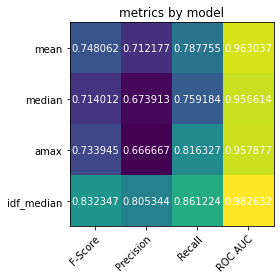

In [117]:
fig, ax = plt.subplots()
im = ax.imshow(metrics_indicators)

ax.set_xticks(np.arange(len(metrics)), labels=metrics)
ax.set_yticks(np.arange(len(models)), labels=models)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(metrics)):
    for j in range(len(models)):
        text = ax.text(j, i, metrics_indicators[i, j],
                       ha="center", va="center", color="white")

ax.set_title("metrics by model")
fig.tight_layout()
plt.show()

На основании проведенных исследований было выявлено, что самые высокие показатели получили метрики, расчитанные с применением tfidf, который характеризует отношение числа вхождений конкретного слова к общему набору слов в документе, а так же инверсию частоты вхождений (idf). Наиболее очевидной мерой качества в задаче классификации является доля правильных ответов (accuracy), однако она имеет так же ряд недостатков в применении к несбалансированным классам и чувствительна к выбросам. По этой причине логично было использовать критерий AUC-ROC, он устойчив к несбалансированным классам и может быть интерпретирован как вероятность того, что случайно выбранный positive объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть positive), чем случайно выбранный negative объект. На примере наших данных и полученных значений можно убедиться, что модель с применением idf дала лучший результат по данному критерию, а так же лучшую точность и полноту. Вторая по качеству модель была посчитана на средних (mean) значениях имбедингов пользователей. Медиана же дает практически бесполезный результат, не смотря на то что все же AUC чуть выше 0,95, точность, полнота и F-мера очень близки др. др. и не превышают значений при средней. Использование максимальных значений даел результат лучше медианного, но не значительно, при не плохом показателе полноты, точность значительно снижается, что свидетельствует о чувствительности модели к предельным показателям.
